# This notebook will be mainly used for the capstone project (The Battle of Neighborhoods)

## The goal is to compare the neighborhoods of the cities of Toronto and New York and determine how similar or dissimilar they are

## 0. Import Library and Define Foursquare Credentials and Version

In [276]:
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
import matplotlib.pyplot as plt

CLIENT_ID = 'MQXCFS52UNJB2Y50K0V2YDR4C1G2541AASTO5LV0FIX2TLFI' # your Foursquare ID
CLIENT_SECRET = 'Q1I20DPW5XKSR2EXXZ2R0M3J4RSRCQ2BLR0PPV0DPQGJDDUW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MQXCFS52UNJB2Y50K0V2YDR4C1G2541AASTO5LV0FIX2TLFI
CLIENT_SECRET:Q1I20DPW5XKSR2EXXZ2R0M3J4RSRCQ2BLR0PPV0DPQGJDDUW


## 1. Download and Explore Dataset Toronto

### Import webpage url and extract table 

In [91]:
# Webpage url                                                                                                               
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Extract tables
dfs = pd.read_html(url)

### Get first table

In [92]:
# Get first table                                                                                                           
df = dfs[0]
                                                                                                          
df.head(10)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [93]:
df.shape

(180, 3)

### Ignore cells with a borough that is Not assigned
### NB: The neighborhoods are already separated with a comma and are assigned 

In [94]:
df1 = df[df["Borough"]!="Not assigned"]

In [95]:
df1.head(10)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [96]:
df1.shape

(103, 3)

### Read csv file that has the geographical coordinates of each postal code

In [97]:
df_geo = pd.read_csv("file/Geospatial_Coordinates.csv")

In [98]:
df_geo.head(10)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [99]:
df_geo.shape

(103, 3)

### Merge Neighbourhood dataframe with Geo dataframe

In [100]:
toronto_data = pd.merge(df1,df_geo,on='Postal Code')

In [101]:
toronto_data.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [102]:
toronto_data.shape

(103, 5)

In [103]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


### Use geopy library to get the latitude and longitude values of Toronto.

In [104]:
address = 'Toronto'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [105]:
toronto_data.dtypes

Postal Code       object
Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
dtype: object

### Create a map of Toronto with neighborhoods superimposed on top.

In [106]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map

for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

    
map_toronto

In [107]:
toronto_data.head(39)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## 2. Download and Explore Dataset New York

In [108]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


"wget" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [109]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [110]:
neighborhoods_data = newyork_data['features']

In [111]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [112]:
# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_newyork = pd.DataFrame(columns=column_names)

In [113]:
neighborhoods_newyork

,Borough,Neighbourhood,Latitude,Longitude


In [114]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_newyork = neighborhoods_newyork.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [115]:
neighborhoods_newyork.head(40)

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [116]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods_newyork['Borough'].unique()),
        neighborhoods_newyork.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [117]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [118]:
neighborhoods_newyork.dtypes

Borough           object
Neighbourhood     object
Latitude         float64
Longitude        float64
dtype: object

In [120]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods_newyork['Latitude'], neighborhoods_newyork['Longitude'], neighborhoods_newyork['Borough'], neighborhoods_newyork['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [229]:
neighborhoods_newyork.shape

(306, 4)

## 3. Explore neighborhoods in boroughs in Toronto

In [121]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues

In [122]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

### Let's check the size of the resulting dataframe

In [123]:
print(toronto_venues.shape)
toronto_venues.head()

(2128, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [124]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,3,3,3,3,3,3


### Let's find out how many unique categories can be curated from all the returned venues

In [125]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 270 uniques categories.


## 4. Explore neighborhoods in boroughs in New York

In [126]:
newyork_venues = getNearbyVenues(names=neighborhoods_newyork['Neighbourhood'],
                                   latitudes=neighborhoods_newyork['Latitude'],
                                   longitudes=neighborhoods_newyork['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [127]:
print(newyork_venues.shape)
newyork_venues.head()

(10159, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [128]:
newyork_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,31,31,31,31,31,31
Annadale,11,11,11,11,11,11
Arden Heights,6,6,6,6,6,6
Arlington,4,4,4,4,4,4
Arrochar,23,23,23,23,23,23
...,...,...,...,...,...,...
Woodhaven,26,26,26,26,26,26
Woodlawn,26,26,26,26,26,26
Woodrow,17,17,17,17,17,17


In [129]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 431 uniques categories.


## 5. Analyze Each Neighborhood in Toronto

In [132]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
toronto_onehot.shape

(2128, 270)

### Next, let's group rows by Neighborhood and by taking the mean of the frequency of occurrence of each category

In [134]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.00
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00


### Let's confirm the new size

In [135]:
toronto_grouped.shape

(95, 270)

### Let's print each neighborhood along with the top 5 most common venues

In [136]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot  0.25
1  Latin American Restaurant  0.25
2               Skating Rink  0.25
3                     Lounge  0.25
4                Men's Store  0.00


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.25
1  Athletics & Sports  0.12
2         Coffee Shop  0.12
3                 Pub  0.12
4      Sandwich Place  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0  Coffee Shop  0.10
1         Bank  0.10
2  Pizza Place  0.05
3  Gas Station  0.05
4     Pharmacy  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1  Japanese Restaurant  0.25
2                 Bank  0.25
3   Chinese Restaurant  0.25
4                Motel  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1      Sandwich Place  0.08
2         Coffee Shop  0.08
3    Toy / Game Store  0.04
4  

### Let's put that into a _pandas_ dataframe

In [137]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [138]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
postal_code_venues_sorted = pd.DataFrame(columns=columns)
postal_code_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    postal_code_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

postal_code_venues_sorted.head(40)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Athletics & Sports,Pharmacy,Sandwich Place,Pub,Discount Store,Dessert Shop,Dim Sum Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Frozen Yogurt Shop,Diner,Sandwich Place,Bridal Shop,Deli / Bodega,Restaurant,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Women's Store,Pharmacy,Indian Restaurant,Butcher,Pub,Sushi Restaurant,Café
5,Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Cheese Shop,Seafood Restaurant,Beer Bar,Bakery,Farmers Market,Beach,Jazz Club
6,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
7,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Furniture / Home Store,Performing Arts Venue,Pet Store,Convenience Store,Climbing Gym,Restaurant,Burrito Place
8,"Business reply mail Processing Centre, South C...",Light Rail Station,Garden Center,Skate Park,Farmers Market,Fast Food Restaurant,Brewery,Burrito Place,Restaurant,Smoke Shop,Park
9,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Coffee Shop,Bar,Boat or Ferry,Rental Car Location,Airport Gate,Airport Food Court


In [139]:
postal_code_venues_sorted.shape

(95, 11)

## 6. Analyze Each Neighborhood in New York

In [141]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
newyork_onehot.shape

(10159, 431)

In [143]:
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
1,Annadale,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
2,Arden Heights,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
3,Arlington,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
4,Arrochar,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,Woodhaven,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
297,Woodlawn,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
298,Woodrow,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.0,0.0
299,Woodside,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.037500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0125,0.0,0.0


In [144]:
newyork_grouped.shape

(301, 431)

In [145]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0         Pizza Place  0.16
1       Deli / Bodega  0.10
2  Chinese Restaurant  0.06
3         Supermarket  0.06
4         Bus Station  0.03


----Annadale----
           venue  freq
0         Bakery  0.09
1    Pizza Place  0.09
2  Deli / Bodega  0.09
3   Dance Studio  0.09
4     Restaurant  0.09


----Arden Heights----
              venue  freq
0     Deli / Bodega  0.17
1       Coffee Shop  0.17
2       Pizza Place  0.17
3          Bus Stop  0.17
4  Business Service  0.17


----Arlington----
                 venue  freq
0                  ATM  0.25
1        Deli / Bodega  0.25
2  American Restaurant  0.25
3             Bus Stop  0.25
4          Yoga Studio  0.00


----Arrochar----
                venue  freq
0            Bus Stop  0.13
1       Deli / Bodega  0.09
2          Bagel Shop  0.09
3  Italian Restaurant  0.09
4         Pizza Place  0.09


----Arverne----
            venue  freq
0       Surf Spot  0.20
1   Metro Station  0.10
2  Sand

In [146]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [147]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Bus Station,Gym / Fitness Center,Fast Food Restaurant,Bike Trail,Martial Arts School,Electronics Store
1,Annadale,Pizza Place,Restaurant,Train Station,Liquor Store,Pharmacy,Food,Diner,Bakery,Deli / Bodega,Park
2,Arden Heights,Pizza Place,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Business Service,Women's Store,Exhibit,Factory,Falafel Restaurant
3,Arlington,ATM,Deli / Bodega,American Restaurant,Bus Stop,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Bagel Shop,Food Truck,Hotel,Liquor Store,Athletics & Sports,Pharmacy


## 7. Cluster Neighborhoods in New York merged with Toronto

In [ ]:
newyork_grouped.insert(0, 'City', 'New York')

In [263]:
newyork_grouped.head()

,City,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,New York,Allerton,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,New York,Annadale,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,New York,Arden Heights,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,New York,Arlington,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,New York,Arrochar,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [264]:
newyork_grouped.head()

,City,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,New York,Allerton,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,New York,Annadale,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,New York,Arden Heights,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,New York,Arlington,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,New York,Arrochar,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
toronto_grouped.head()

,City,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Toronto,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,Toronto,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,Toronto,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,Toronto,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,Toronto,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04


In [156]:
toronto_grouped.insert(0, 'City', 'Toronto')

In [265]:
toronto_grouped.head(25)

,City,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Toronto,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
1,Toronto,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
2,Toronto,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
3,Toronto,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
4,Toronto,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.04
5,Toronto,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
6,Toronto,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
7,Toronto,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
8,Toronto,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00
9,Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.000000,0.066667,0.066667,0.066667,0.133333,0.133333,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00


In [266]:
newyork_grouped.shape

(301, 432)

In [267]:
toronto_grouped.shape

(95, 271)

In [268]:
tot_grouped = newyork_grouped.append(toronto_grouped,ignore_index = True)

In [269]:
tot_grouped.head(25)

,City,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,...,Indoor Play Area,Knitting Store,Korean BBQ Restaurant,Light Rail Station,Luggage Store,Portuguese Restaurant,Poutine Place,Swim School,Theme Restaurant,Truck Stop
0,New York,Allerton,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,New York,Annadale,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,New York,Arden Heights,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,New York,Arlington,0.000000,0.25,0.000000,0.0,0.0,0.0,0.0,0.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,New York,Arrochar,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,New York,Arverne,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,New York,Astoria,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,New York,Astoria Heights,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,New York,Auburndale,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.055556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,New York,Bath Beach,0.000000,0.00,0.020408,0.0,0.0,0.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [270]:
tot_grouped.shape

(396, 463)

In [271]:
tot_grouped.fillna(0, inplace = True)

In [272]:
tot_grouped_clustering = tot_grouped.drop('Neighborhood', 1).drop('City',1)

tot_grouped_clustering.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Indoor Play Area,Knitting Store,Korean BBQ Restaurant,Light Rail Station,Luggage Store,Portuguese Restaurant,Poutine Place,Swim School,Theme Restaurant,Truck Stop
0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [284]:
Sum_of_squared_distances = []
K = range(1,70)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tot_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

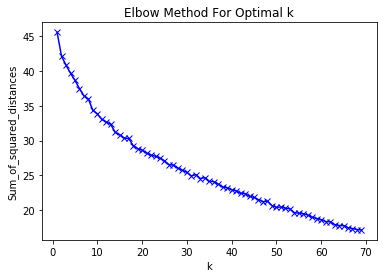

In [285]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [286]:
# set number of clusters
kclusters = 15

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tot_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 9, 0, 0, 0, 9, 8, 9, 8, 9])

In [287]:
tot_venues_sorted = neighborhoods_venues_sorted.append(postal_code_venues_sorted, ignore_index = True)

In [288]:
tot_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Bus Station,Gym / Fitness Center,Fast Food Restaurant,Bike Trail,Martial Arts School,Electronics Store
1,Annadale,Pizza Place,Restaurant,Train Station,Liquor Store,Pharmacy,Food,Diner,Bakery,Deli / Bodega,Park
2,Arden Heights,Pizza Place,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Business Service,Women's Store,Exhibit,Factory,Falafel Restaurant
3,Arlington,ATM,Deli / Bodega,American Restaurant,Bus Stop,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm
4,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Bagel Shop,Food Truck,Hotel,Liquor Store,Athletics & Sports,Pharmacy


In [289]:
# add clustering labels
tot_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tot_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Bus Station,Gym / Fitness Center,Fast Food Restaurant,Bike Trail,Martial Arts School,Electronics Store
1,9,Annadale,Pizza Place,Restaurant,Train Station,Liquor Store,Pharmacy,Food,Diner,Bakery,Deli / Bodega,Park
2,0,Arden Heights,Pizza Place,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Business Service,Women's Store,Exhibit,Factory,Falafel Restaurant
3,0,Arlington,ATM,Deli / Bodega,American Restaurant,Bus Stop,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm
4,0,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Bagel Shop,Food Truck,Hotel,Liquor Store,Athletics & Sports,Pharmacy


In [290]:
tot_venues_sorted.dtypes

Cluster Labels             int32
Neighborhood              object
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
6th Most Common Venue     object
7th Most Common Venue     object
8th Most Common Venue     object
9th Most Common Venue     object
10th Most Common Venue    object
dtype: object

In [291]:
tot_venues_sorted.shape

(396, 12)

In [293]:
tot_merged = toronto_data.drop('Postal Code',1).append(neighborhoods_newyork,ignore_index = True)

tot_merged.head()

,City,Borough,Neighbourhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [294]:
tot_merged.shape

(409, 5)

In [295]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each postal code
#tot_merged = tot_merged.join(tot_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

result = pd.merge(tot_venues_sorted, tot_merged, how="left", left_on=['Neighborhood'], right_on=['Neighbourhood'])

result.head() # check the last columns!

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Borough,Neighbourhood,Latitude,Longitude
0,2,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Bus Station,Gym / Fitness Center,Fast Food Restaurant,Bike Trail,Martial Arts School,Electronics Store,New York,Bronx,Allerton,40.865788,-73.859319
1,9,Annadale,Pizza Place,Restaurant,Train Station,Liquor Store,Pharmacy,Food,Diner,Bakery,Deli / Bodega,Park,New York,Staten Island,Annadale,40.538114,-74.178549
2,0,Arden Heights,Pizza Place,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Business Service,Women's Store,Exhibit,Factory,Falafel Restaurant,New York,Staten Island,Arden Heights,40.549286,-74.185887
3,0,Arlington,ATM,Deli / Bodega,American Restaurant,Bus Stop,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm,New York,Staten Island,Arlington,40.635325,-74.165104
4,0,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Bagel Shop,Food Truck,Hotel,Liquor Store,Athletics & Sports,Pharmacy,New York,Staten Island,Arrochar,40.596313,-74.067124


In [296]:
result.dtypes

Cluster Labels              int32
Neighborhood               object
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
City                       object
Borough                    object
Neighbourhood              object
Latitude                  float64
Longitude                 float64
dtype: object

In [240]:
result.shape

(406, 16)

In [297]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result['Latitude'], result['Longitude'], result['Neighbourhood'], result['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 8. Examine Clusters

### Cluster 1

In [298]:
result.loc[result['Cluster Labels'] == 0, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,0,New York,Arden Heights,Pizza Place,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Business Service,Women's Store,Exhibit,Factory,Falafel Restaurant
3,0,New York,Arlington,ATM,Deli / Bodega,American Restaurant,Bus Stop,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm
4,0,New York,Arrochar,Bus Stop,Italian Restaurant,Deli / Bodega,Pizza Place,Bagel Shop,Food Truck,Hotel,Liquor Store,Athletics & Sports,Pharmacy
27,0,New York,Bloomfield,Recreation Center,Theme Park,Burger Joint,Bus Stop,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
37,0,New York,Brookville,Recording Studio,Deli / Bodega,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
64,0,New York,Concord,Vegetarian / Vegan Restaurant,Bus Stop,Gym / Fitness Center,Grocery Store,Train Station,Coffee Shop,Peruvian Restaurant,Deli / Bodega,Food & Drink Shop,Food
108,0,New York,Fox Hills,American Restaurant,Bus Stop,Grocery Store,Sandwich Place,Women's Store,Film Studio,Event Space,Exhibit,Factory,Falafel Restaurant
119,0,New York,Grasmere,Bus Stop,Bank,Bagel Shop,Italian Restaurant,Vegetarian / Vegan Restaurant,Cosmetics Shop,Restaurant,Pizza Place,Pharmacy,Park
125,0,New York,Grymes Hill,Dog Run,Deli / Bodega,Bus Stop,Flea Market,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
170,0,New York,Mariner's Harbor,Italian Restaurant,Deli / Bodega,Bus Stop,Supermarket,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market


### Cluster 2

In [299]:
result.loc[result['Cluster Labels'] == 1, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,1,New York,Bergen Beach,Harbor / Marina,Park,Playground,Baseball Field,Athletics & Sports,Women's Store,Exhibit,Factory,Falafel Restaurant,Farm
57,1,New York,Clason Point,Park,South American Restaurant,Convenience Store,Grocery Store,Boat or Ferry,Pool,Bus Stop,Women's Store,Exhibit,Factory
218,1,New York,Port Richmond,Rental Car Location,Park,Pizza Place,Donut Shop,Entertainment Service,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant
257,1,New York,South Ozone Park,Park,Bar,Sandwich Place,Hotel,Fast Food Restaurant,Donut Shop,Deli / Bodega,Food Truck,Factory,Falafel Restaurant
316,1,Toronto,Caledonia-Fairbanks,Park,Pool,Women's Store,Gourmet Shop,Escape Room,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
336,1,Toronto,"East Toronto, Broadview North (Old East York)",Intersection,Park,Convenience Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Department Store
340,1,Toronto,"Forest Hill North & West, Forest Hill Road Park",Park,Sushi Restaurant,Jewelry Store,Trail,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
342,1,Toronto,Glencairn,Park,Bakery,Japanese Restaurant,Pub,Women's Store,Distribution Center,Dim Sum Restaurant,Diner,Discount Store,Dog Run
350,1,Toronto,Humewood-Cedarvale,Trail,Park,Field,Hockey Arena,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
354,1,Toronto,"Kingsview Village, St. Phillips, Martin Grove ...",Park,Pizza Place,Sandwich Place,Bus Line,Drugstore,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Dance Studio


### Cluster 3

In [300]:
result.loc[result['Cluster Labels'] == 2, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,New York,Allerton,Pizza Place,Deli / Bodega,Supermarket,Chinese Restaurant,Bus Station,Gym / Fitness Center,Fast Food Restaurant,Bike Trail,Martial Arts School,Electronics Store
24,2,New York,Bensonhurst,Pizza Place,Italian Restaurant,Chinese Restaurant,Grocery Store,Ice Cream Shop,Sushi Restaurant,Donut Shop,Park,Shabu-Shabu Restaurant,Bar
29,2,New York,Borough Park,Bank,Deli / Bodega,Pizza Place,Pharmacy,Fast Food Restaurant,Hotel,Chinese Restaurant,Grocery Store,Coffee Shop,Farmers Market
33,2,New York,Broad Channel,Pizza Place,Deli / Bodega,Sporting Goods Shop,Bus Station,Dive Bar,Other Nightlife,Women's Store,Exhibit,Factory,Falafel Restaurant
39,2,New York,Bulls Head,Bus Stop,Pizza Place,Chinese Restaurant,Grocery Store,Sandwich Place,Pharmacy,Deli / Bodega,Café,Gift Shop,Liquor Store
46,2,New York,Castle Hill,Diner,Bank,Baseball Field,Deli / Bodega,Pharmacy,Pizza Place,Market,Farm,Field,Fast Food Restaurant
47,2,New York,Castleton Corners,Pizza Place,Japanese Restaurant,Go Kart Track,Grocery Store,Tattoo Parlor,Skating Rink,Bar,Bagel Shop,Sandwich Place,Bank
61,2,New York,Co-op City,Baseball Field,Bus Station,Pizza Place,Grocery Store,Pharmacy,Discount Store,Restaurant,Post Office,Bagel Shop,Park
70,2,New York,Crown Heights,Pizza Place,Café,Museum,Bakery,Deli / Bodega,Bagel Shop,Salon / Barbershop,Coffee Shop,Candy Store,Bookstore
73,2,New York,Dongan Hills,Pizza Place,Italian Restaurant,Bagel Shop,Pharmacy,Flower Shop,Sushi Restaurant,Fast Food Restaurant,Smoke Shop,Tattoo Parlor,Chinese Restaurant


### Cluster 4

In [301]:
result.loc[result['Cluster Labels'] == 3, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
253,3,New York,Somerville,Park,Women's Store,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
273,3,New York,Todt Hill,Park,Women's Store,Ethiopian Restaurant,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
400,3,Toronto,"Willowdale, Newtonbrook",Park,Deli / Bodega,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


### Cluster 5

In [302]:
result.loc[result['Cluster Labels'] == 4, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
201,4,New York,Oakwood,Bar,Lawyer,Nightlife Spot,Home Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
216,4,New York,Port Ivory,Bar,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
366,4,Toronto,"Northwest, West Humber - Clairville",Truck Stop,Bar,Rental Car Location,Drugstore,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store
378,4,Toronto,"Rouge Hill, Port Union, Highland Creek",Home Service,Bar,Construction & Landscaping,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


### Cluster 6

In [303]:
result.loc[result['Cluster Labels'] == 5, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,5,New York,Butler Manor,Baseball Field,Pool,Gas Station,Bus Stop,Women's Store,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant,Farm
179,5,New York,Mill Island,Other Repair Shop,Pool,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
377,5,Toronto,Roselawn,Garden,Pool,Women's Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
392,5,Toronto,"The Kingsway, Montgomery Road, Old Mill North",Park,River,Pool,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


### Cluster 7

In [304]:
result.loc[result['Cluster Labels'] == 6, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
349,6,Toronto,"Humberlea, Emery",Baseball Field,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,Farmers Market
368,6,Toronto,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Baseball Field,Home Service,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store


### Cluster 8

In [305]:
result.loc[result['Cluster Labels'] == 7, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,7,New York,Bayswater,Playground,Women's Store,Film Studio,Event Service,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
381,7,Toronto,Scarborough Village,Health & Beauty Service,Playground,Women's Store,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


### Cluster 9

In [306]:
result.loc[result['Cluster Labels'] == 8, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,8,New York,Astoria,Bar,Middle Eastern Restaurant,Seafood Restaurant,Greek Restaurant,Hookah Bar,Bakery,Indian Restaurant,Mediterranean Restaurant,Café,Food Truck
8,8,New York,Auburndale,Italian Restaurant,Mattress Store,Fast Food Restaurant,Train Station,Toy / Game Store,Athletics & Sports,Pharmacy,Pet Store,Hookah Bar,Supermarket
10,8,New York,Battery Park City,Coffee Shop,Park,Hotel,Clothing Store,Gym,Memorial Site,Burger Joint,Boat or Ferry,Shopping Mall,Food Court
11,8,New York,Bay Ridge,Spa,Italian Restaurant,Pizza Place,American Restaurant,Bagel Shop,Bar,Greek Restaurant,Playground,Chinese Restaurant,Sushi Restaurant
15,8,New York,Bayside,Bar,Pizza Place,Sushi Restaurant,Pub,Mexican Restaurant,Indian Restaurant,Italian Restaurant,Donut Shop,Steakhouse,Ice Cream Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,8,Toronto,"University of Toronto, Harbord",Café,Bookstore,Bakery,Bar,Italian Restaurant,Japanese Restaurant,Sandwich Place,Bank,Beer Bar,Beer Store
396,8,Toronto,Victoria Village,Hockey Arena,Pizza Place,French Restaurant,Portuguese Restaurant,Intersection,Coffee Shop,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
401,8,Toronto,"Willowdale, Willowdale East",Ramen Restaurant,Café,Coffee Shop,Restaurant,Sandwich Place,Shopping Mall,Pizza Place,Bubble Tea Shop,Electronics Store,Japanese Restaurant
403,8,Toronto,Woburn,Coffee Shop,Korean BBQ Restaurant,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore


### Cluster 10

In [307]:
result.loc[result['Cluster Labels'] == 9, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,9,New York,Annadale,Pizza Place,Restaurant,Train Station,Liquor Store,Pharmacy,Food,Diner,Bakery,Deli / Bodega,Park
5,9,New York,Arverne,Surf Spot,Sandwich Place,Metro Station,Restaurant,Coffee Shop,Café,Donut Shop,Thai Restaurant,Pizza Place,Board Shop
7,9,New York,Astoria Heights,Italian Restaurant,Plaza,Burger Joint,Supermarket,Bowling Alley,Bus Station,Hostel,Pizza Place,Playground,Bakery
9,9,New York,Bath Beach,Chinese Restaurant,Bubble Tea Shop,Italian Restaurant,Fast Food Restaurant,Gas Station,Halal Restaurant,Pharmacy,Peruvian Restaurant,Donut Shop,Russian Restaurant
12,9,New York,Bay Terrace,Clothing Store,Supermarket,Donut Shop,Women's Store,Cosmetics Shop,American Restaurant,Shoe Store,Kids Store,Men's Store,Mobile Phone Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,9,Toronto,"Golden Mile, Clairlea, Oakridge",Bakery,Ice Cream Shop,Bus Station,Metro Station,Intersection,Bus Line,Soccer Field,Park,Construction & Landscaping,Convenience Store
344,9,Toronto,"Guildwood, Morningside, West Hill",Mexican Restaurant,Electronics Store,Restaurant,Rental Car Location,Intersection,Breakfast Spot,Bank,Medical Center,Discount Store,Dim Sum Restaurant
361,9,Toronto,"Mimico NW, The Queensway West, South of Bloor,...",Grocery Store,Tanning Salon,Convenience Store,Burrito Place,Burger Joint,Discount Store,Sandwich Place,Kids Store,Supplement Shop,Bakery
393,9,Toronto,Thorncliffe Park,Sandwich Place,Indian Restaurant,Discount Store,Restaurant,Burger Joint,Fast Food Restaurant,Pizza Place,Pharmacy,Bank,Gas Station


### Cluster 11

In [308]:
result.loc[result['Cluster Labels'] == 10, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
359,10,Toronto,"Malvern, Rouge",Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


### Cluster 12

In [309]:
result.loc[result['Cluster Labels'] == 11, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
294,11,New York,Westerleigh,Health & Beauty Service,Convenience Store,Arcade,Women's Store,Fish Market,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
398,11,Toronto,Weston,Convenience Store,Jewelry Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,Dessert Shop


### Cluster 13

In [310]:
result.loc[result['Cluster Labels'] == 12, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,12,New York,Emerson Hill,Construction & Landscaping,Food,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
364,12,Toronto,"North Park, Maple Leaf Park, Upwood Park",Park,Bakery,Construction & Landscaping,Basketball Court,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
405,12,Toronto,York Mills West,Park,Convenience Store,Construction & Landscaping,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Department Store,Ethiopian Restaurant


### Cluster 14

In [311]:
result.loc[result['Cluster Labels'] == 13, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,13,New York,Cambria Heights,Restaurant,Caribbean Restaurant,Chinese Restaurant,Liquor Store,Moving Target,Flower Shop,Gym / Fitness Center,Pharmacy,Cosmetics Shop,Bakery
43,13,New York,Canarsie,Chinese Restaurant,Bus Line,Caribbean Restaurant,Food,Asian Restaurant,Gym,Women's Store,Film Studio,Factory,Falafel Restaurant
79,13,New York,East Flatbush,Chinese Restaurant,Business Service,Park,Department Store,Supermarket,Caribbean Restaurant,Food & Drink Shop,Pharmacy,Moving Target,Farmers Market
94,13,New York,Erasmus,Caribbean Restaurant,Yoga Studio,Playground,Grocery Store,Food Truck,Bank,Mobile Phone Shop,Health Food Store,School,Pharmacy
150,13,New York,Laurelton,Caribbean Restaurant,Cosmetics Shop,Deli / Bodega,Park,Train Station,Women's Store,Film Studio,Exhibit,Factory,Falafel Restaurant
205,13,New York,Olinville,Supermarket,Caribbean Restaurant,Bakery,Deli / Bodega,Metro Station,Mexican Restaurant,Convenience Store,Food,Film Studio,Factory
230,13,New York,Remsen Village,Caribbean Restaurant,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Gym,Pharmacy,Coffee Shop,Café,Sandwich Place,Donut Shop
261,13,New York,St. Albans,Caribbean Restaurant,Fried Chicken Joint,Health Food Store,Southern / Soul Food Restaurant,Donut Shop,Fast Food Restaurant,Café,Discount Store,Convenience Store,Event Service
296,13,New York,Williamsbridge,Nightclub,Bar,Caribbean Restaurant,Soup Place,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
367,13,Toronto,"Northwood Park, York University",Miscellaneous Shop,Coffee Shop,Caribbean Restaurant,Massage Studio,Bar,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


### Cluster 15

In [312]:
result.loc[result['Cluster Labels'] == 14, result.columns[[0] + [12] + [1] + list(range(2, 12))]]

,Cluster Labels,City,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,14,New York,Breezy Point,Beach,Monument / Landmark,Supermarket,Trail,Fish & Chips Shop,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market
127,14,New York,Hammels,Beach,Fried Chicken Joint,Gym / Fitness Center,Dog Run,Fast Food Restaurant,Bus Stop,Bus Station,Diner,Shoe Store,Food Truck
189,14,New York,Neponsit,Beach,Women's Store,Fish & Chips Shop,Event Space,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
